<a href="https://colab.research.google.com/github/pk2971/computational-gender-analysis/blob/main/notebooks/Word_cloud_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
import xml.etree.ElementTree as ET
import re
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
zip_path = '/content/drive/MyDrive/debates.zip'
# Clean and parse XML text
def extract_text_from_speech(xml_bytes):
    try:
        root = ET.fromstring(xml_bytes)
        return ' '.join([p.text or '' for p in root.findall('.//speech//p')])
    except ET.ParseError:
        return ""

In [22]:
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
def generate_word_cloud(zip_path, year_input, target_word, extra_stopwords=[]):
    # Parse year range
    if isinstance(year_input, int):
        start_year, end_year = year_input, year_input
    else:
        start_year, end_year = year_input

    # Extract and process text
    full_text = ""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if not file_name.endswith('.xml'):
                continue
            base_name = file_name.split('/')[-1]
            year_match = re.search(r'debates(\d{4})', base_name)
            if not year_match:
                continue
            year = int(year_match.group(1))
            if start_year <= year <= end_year:
                with zip_ref.open(file_name) as f:
                    xml_bytes = f.read()
                    full_text += extract_text_from_speech(xml_bytes) + " "

    # Preprocess text: only remove standard English stopwords for co-occurrence
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(full_text.lower())
    words = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Calculate co-occurrences
    window_size = 10
    co_occurrence_counts = defaultdict(int)
    target = target_word.lower()
    for i, current_word in enumerate(words):
        if current_word == target:
            start_idx = max(0, i - window_size // 2)
            end_idx = min(len(words), i + window_size // 2 + 1)
            for j in range(start_idx, end_idx):
                if j == i:
                    continue
                context_word = words[j]
                co_occurrence_counts[context_word] += 1

    # Remove extra_stopwords only from the wordcloud, not from co-occurrence calculation
    for stopword in extra_stopwords:
      co_occurrence_counts.pop(stopword.lower(), None)
    # Generate word cloud
    wordcloud = WordCloud(
        width=1200,
        height=600,
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate_from_frequencies(co_occurrence_counts)

    plt.figure(figsize=(15, 8))
    plt.title(f"Words associated with '{target_word}' ({start_year}-{end_year})", fontsize=20)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


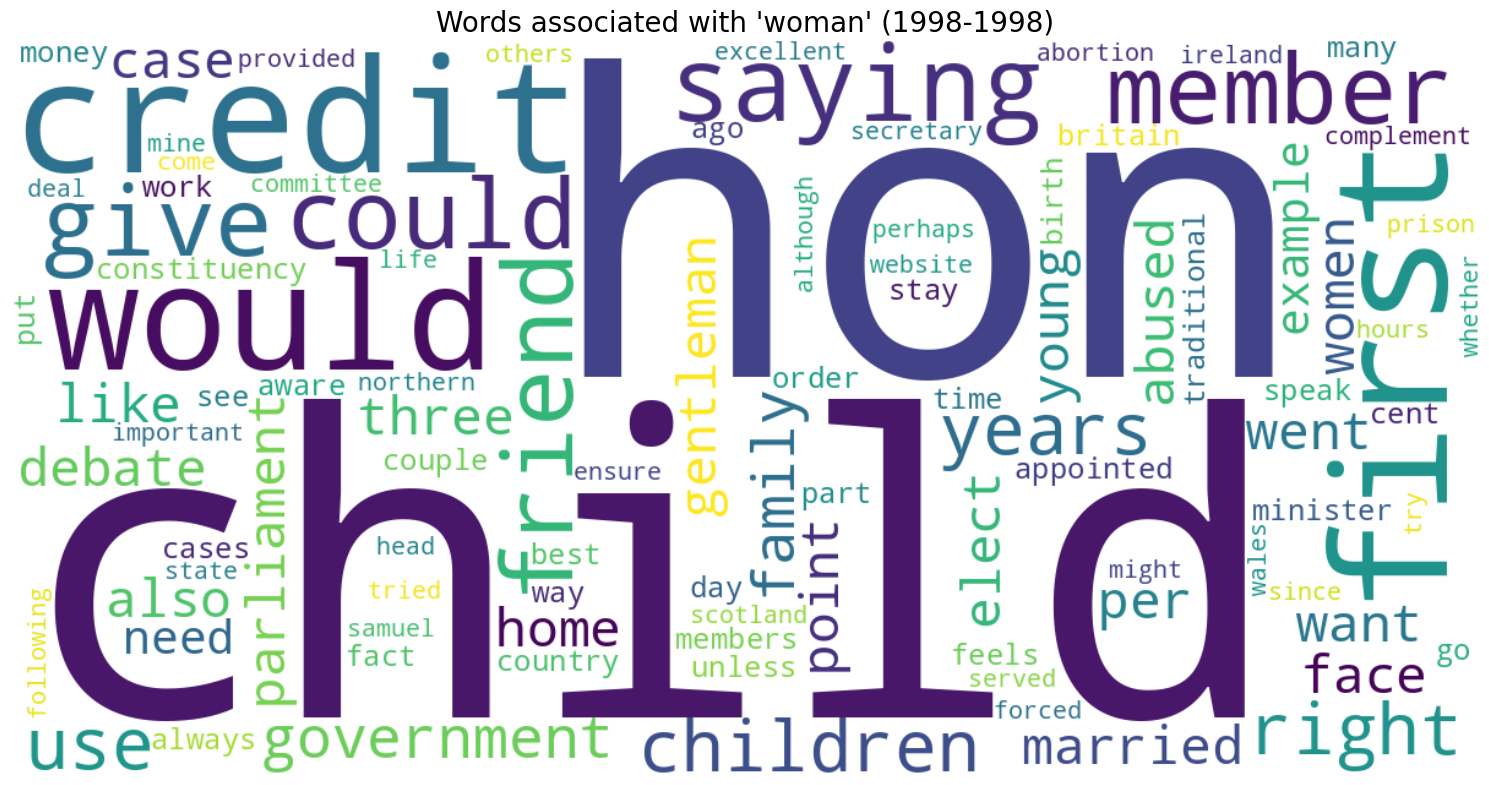

In [40]:
generate_word_cloud(zip_path, 1998, 'woman',['man','woman','men','every','got','one'])

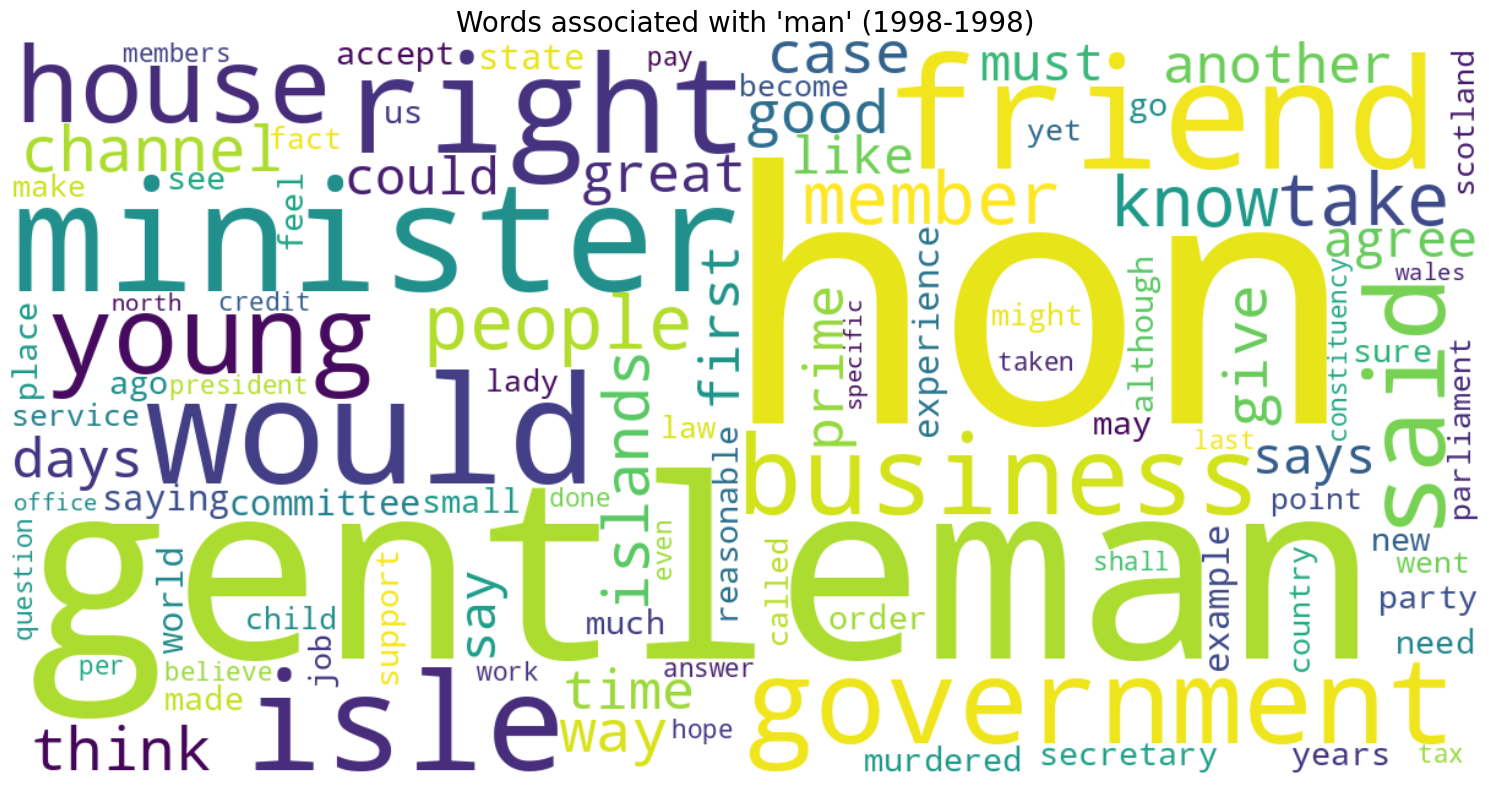

In [41]:
generate_word_cloud(zip_path, 1998, 'man',['man','woman','men','every','got','one'])